In [1]:
import os
import sys
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../../../')
sys.path.append('../../../infras/cellMix/')
sys.path.append('../../../infras/cytof_data/')
sys.path.append('../../../infras/')
sys.path.append('../../../infras/dashboards/')
sys.path.append('../../../experiments/')
sys.path.append('../../../experiments/pipeline/')
sys.path.append('../../../preprocess/intra_variance/')
sys.path.append('../../../models/cell_proportions/')
sys.path.append('../../../measures/cell_proportions_measures/')
sys.path.append('../../../preprocess/cell_specifics/')

from data_factory import DataFactory
from global_utils import GlobalUtils
from aggregate_intra_variance import AggregateIntraVariance

In [3]:
intensity_type = "INTENSITY"

In [4]:
data_factory = DataFactory()
A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",log2_transformation=True,with_granulocytes=True)

pbmc_cels = ['BCellmemory', 'BCellnaive', 'BCellplasma', 'CD4TCellmTregs', 'CD4TCellnaive', 'CD4TCellnTregs', 'CD4TCellTcm', 'CD4TCellTem', 'CD4TCellTemra', 'CD4TCellTh1', 'CD4TCellTh17', 'CD4TCellTh2', 'CD8TCellnaive', 'CD8TCellTcm', 'CD8TCellTem', 'CD8TCellTemra', 'DendriticCD1c', 'DendriticCD304', 'Erythrocytes','Monocytesclassical', 'Monocytesintermediate', 'Monocytesnonclassical', 'NKCellsCD56bright', 'NKCellsCD56dim', 'Thrombocytes']
gran_cells = [ 'GranulocytesBasophil', 'Granulocyteseosinophils', 'Granulocytesneutrophils']

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app


In [5]:
agg_iv = AggregateIntraVariance(how = "max")
A,B = agg_iv.transform([A_all_vs,A_all_vs])
mapping = GlobalUtils.get_corospanding_cell_map_from_lists(A.columns,pbmc_cels + gran_cells)

A = A.rename(columns=mapping)

In [13]:
rest = (A[pbmc_cels] ==0).all(axis=1)
idx_per_gran = {} 

for g_cell in gran_cells : 
    relvent_to_cell =  (A[g_cell] > 0)
    idx_per_gran[g_cell] = A.loc[relvent_to_cell & rest].index
#     print(idx_per_gran[g_cell])


In [14]:
gran_cells_in_mixtures = {}
for gran_cell,idxs in idx_per_gran.items() : 
    gran_cells_in_mixtures[gran_cell] = B_all_vs.loc[idxs].dropna()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()


In [39]:
def in_percentile(my_series, val): 
    myList=sorted(my_series.values.tolist())
    l=len(myList)
    return (val>myList).sum()/l

cell_to_ranks = {}
for gran_cell,mixture_of_genes in gran_cells_in_mixtures.items() : 
    if mixture_of_genes.empty : 
        continue
    cell_to_ranks[gran_cell] = []
    for mixture_name in B_all_vs.columns : 
        mixture = B_all_vs[mixture_name]
        gran_in_mixture = mixture_of_genes[mixture_name]
        percantile_of_unique_genes = [in_percentile(mixture,v) for v in gran_in_mixture.values]
        cell_to_ranks[gran_cell] += percantile_of_unique_genes
        print(f"mixture {mixture_name}, {gran_cell} , percantile of unique genes : {percantile_of_unique_genes}")
        
    
#     plt.hist(np.log(mixture_of_genes.mean(axis=1)), 2, alpha=0.5, label=gran_cell,density=True,)
#     plt.hist(np.log(B_all_vs.mean(axis=1)), 100, alpha=0.5, label='rest',density=True)
#     plt.legend(loc='upper right')
#     plt.show()

mixture 24_v1, Granulocyteseosinophils , percantile of unique genes : [0.5543274634694643, 0.020606968902210566]
mixture 24_v2, Granulocyteseosinophils , percantile of unique genes : [0.5138628699887599, 0.04496065942300487]
mixture 24_v3, Granulocyteseosinophils , percantile of unique genes : [0.4409891345073061, 0.20288497564630947]
mixture 26_v1, Granulocyteseosinophils , percantile of unique genes : [0.36155863619333084, 0.41307605844885725]
mixture 26_v2, Granulocyteseosinophils , percantile of unique genes : [0.4484825777444736, 0.24597227426002247]
mixture 26_v3, Granulocyteseosinophils , percantile of unique genes : [0.3345822405395279, 0.2860621955788685]
mixture 27_v1, Granulocyteseosinophils , percantile of unique genes : [0.4945672536530536, 0.03484451105282878]
mixture 27_v2, Granulocyteseosinophils , percantile of unique genes : [0.44642188085425255, 0.005432746346946422]
mixture 27_v3, Granulocyteseosinophils , percantile of unique genes : [0.46740352191832146, 0.0354065

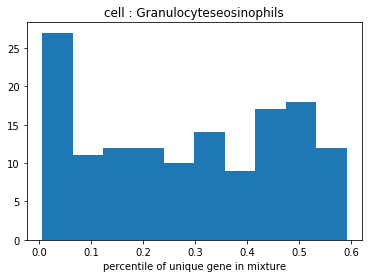

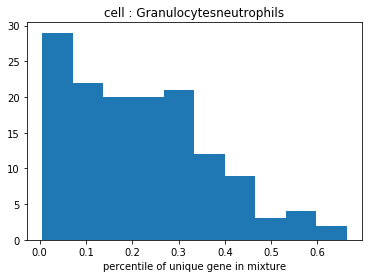

In [42]:
for cell,ranks in  cell_to_ranks.items() : 
    plt.hist(ranks)
    plt.title(f"cell : {cell}")
    plt.xlabel("percentile of unique gene in mixture")
    plt.show()